In [1]:
using FFTW

In [2]:
using Statistics

In [3]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: Error requiring `StaticArrays` from `ArrayInterface`
│   exception = (ErrorException("too many parameters for type"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000068f84117, Ptr{Nothing} @0x0000000068ff06a9, Ptr{Nothing} @0x000000006901236c, Ptr{Nothing} @0x0000000069012031, Ptr{Nothing} @0x0000000069012b40, Ptr{Nothing} @0x0000000069013515, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 82, Ptr{Nothing} @0x0000000069030c9d, Ptr{Nothing} @0x000000006903241a, Ptr{Nothing} @0x00000000249f64bf, Ptr{Nothing} @0x00000000249f64e3, Ptr{Nothing} @0x000000001a1dc5a1, Ptr{Nothing} @0x00000000249f640a, Ptr{Nothing} @0x00000000249f6433, Ptr{Nothing} @0x000000001a1dbf08, Ptr{Nothing} @0x00000000249f6371, Ptr{Nothing} @0x00000000249f63a3, Ptr{Nothing} @0x000000001a1d7afe, Ptr{Nothing} @0x000000001a1dea64, Ptr{Nothing} @0x000000001a1ded83, Ptr{Nothing} @0x0000000069030130, Ptr{Nothing} @0x0000000069026590, Ptr{Nothing} @0x000000001a18d317, Ptr{No

In [4]:
using Plots
gr()  

Plots.GRBackend()

# Properies

### Earth property

In [5]:
g = 9.8

9.8

### Solid Physical parameters

In [6]:
ρₛ = 2730; # density
# cₛ  = 8.97e02; # specific heat
cₛ  = 8.93e02; # specific heat
# kₛ  = 1.67e02; # heat conductivity
kₛ  = 1.93e02; # heat conductivity
# d = 2e-3;
plate_d = 1.5e-3;  # plate thickness
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.0015)

### Fluid Physical parameters

In [7]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

In [8]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

αₗ = kₗ/ρₗ/Cpₗ
νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [9]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [10]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0006333345639056725, 0.001520002953373614)

### Set up the evaporator and condenser

In [11]:
inch = 2.54e-2;

In [12]:
power = 40 #watts
total_heater_area = 2.0inch*2.0inch;

In [13]:
qe = power/total_heater_area
hc = 1500.0 *1.5
Tc = Tᵥ

291.2

In [14]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [15]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = 1e-3
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
# one_loop_gap = 1e-2
# x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


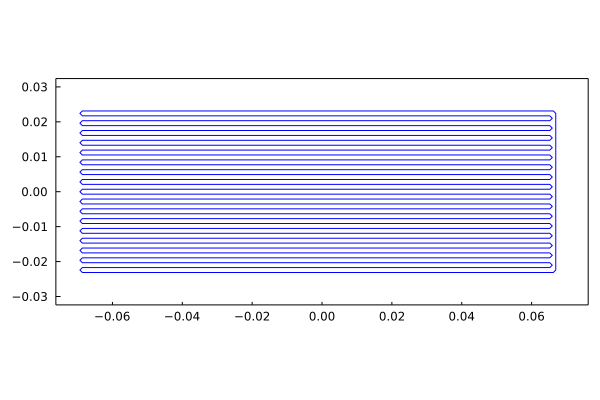

In [16]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [17]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{4877,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [18]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


In [19]:
qtmp = zeros(numpts(ohp));

In [20]:
u0 = newstate(sys)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys);
Tn = temperature(integrator) .+ Tᵥ;

In [21]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


In [22]:
num = 100
ΔN = 100


Thist=[]

@time for i = 1:num
    Tn = ADI_timemarching!(Tn,sys,Δt)
    
    if mod(i,ΔN) == 0
        push!(Thist,deepcopy(Tn))
    end
end

  2.720287 seconds (2.74 M allocations: 1.187 GiB, 6.98% gc time)


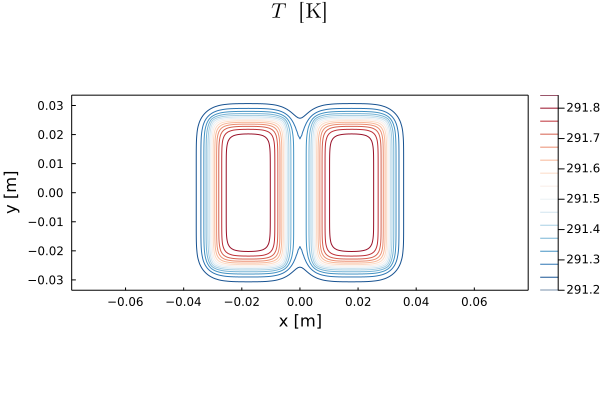

In [23]:
plot(Tn,sys.grid,legend=true,color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

# OHP inner part

### Tube geometries

In [24]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

true

In [25]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,g,closedornot);

### Liquid

In [66]:
Nu = 4.36
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

469.15728016589026

In [67]:
X0,realratio = randomXp(L,numofslugs=30,chargeratio=0.45)
# X0 = [(L/2,L/2+L2D)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r);

In [68]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [69]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,σ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [70]:
Hᵥ = kᵥ/tube_d * Nu # Nusselt number 4.36

69.29503570524817

In [71]:
P = 0*zeros(length(X0)) .+ TtoP(Tᵥ);
δ = 0*zeros(length(X0)) .+ 1.0e-5;
# δratio = 0*zeros(length(X0)) .+ 0.99;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
δmin = mean(δ) * 0.5
vapors=Vapor(Hᵥ,kₗ,δmin,P,δ);

### Wall

### nucleate boiling sites

In [140]:
ΔTthres = 1.0; # superheat threshold

In [141]:
    nucleatenum = 256
#     Xstations = sort(rand(nucleatenum).*L);
    Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

256-element LinRange{Float64}:
 0.0,0.0181667,0.0363334,0.0545,…,4.55984,4.578,4.59617,4.61434,4.6325

In [142]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [143]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [144]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [145]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [146]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# load old data

In [147]:
# integrator_plate = load("plate_OHP_dimensional50D1.0TH1_H2250_platethickness1.5.jld2", "integrator_plate")
# sys = integrator_plate.p

In [148]:
# integrator_tube = load("tube_OHP_dimensional50D1.0TH1_H2250_platethickness1.5.jld2", "integrator_tube")

# # sysfinal = []
# # for i = 1:length(tube_hist)
# #     push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
# # end

In [149]:
# tube_hist = load("tube_vibration.jld2", "tube_hist")

# combine inner tube and plate together

In [207]:
tspan = (0.0, 1.0);
dt_record = tspan[2] /100;
# dt_record = 0.1;

tstep=5e-4

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [208]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ;

In [209]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

## Resume

In [210]:
# integrator_plate = plate_hist[end-1]

In [211]:
# integrator_tube = tube_hist[end-1]

## Start

In [212]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

In [213]:
@time for t in tspan[1]:tstep:tspan[2]
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
    
    
      for j in 1:N_iter
        currentsys.wall.θarray = temperature_linesource(integrator_plate)
        currentsys = getcurrentsys(integrator_tube.u,currentsys)

        qtmp = sys_to_heatflux(currentsys)
        set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.010000000000000005
0.020000000000000014
0.030000000000000023
0.04000000000000003
0.05000000000000004
0.060000000000000046
0.07000000000000005
0.08000000000000006
0.09000000000000007
0.10000000000000007
0.11000000000000008
0.12000000000000009
0.1300000000000001
0.1400000000000001
0.1500000000000001
0.16000000000000011
0.17000000000000012
0.18000000000000013
0.19000000000000014
0.20000000000000015
0.21000000000000016
0.22000000000000017
0.23000000000000018
0.24000000000000019
0.25000000000000017
0.2600000000000002
0.2700000000000002
0.2800000000000002
0.2900000000000002
0.3000000000000002
0.3100000000000002
0.32000000000000023
0.33000000000000024
0.34000000000000025
0.35000000000000026
0.36000000000000026
0.3700000000000003
0.3800000000000003
0.3900000000000003
0.4000000000000003
0.4100000000000003
0.4200000000000003
0.4300000000000003
0.44000000000000034
0.45000000000000034
0.46000000000000035
0.47000000000000036
0.48000000000000037
0.4900000000000004
0.5000000000000003
0.509999999999

In [214]:
(3.424850006344033-3.4123866689301567)/tstep

24.92667482775257

In [215]:
L

4.650670248837521

In [216]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
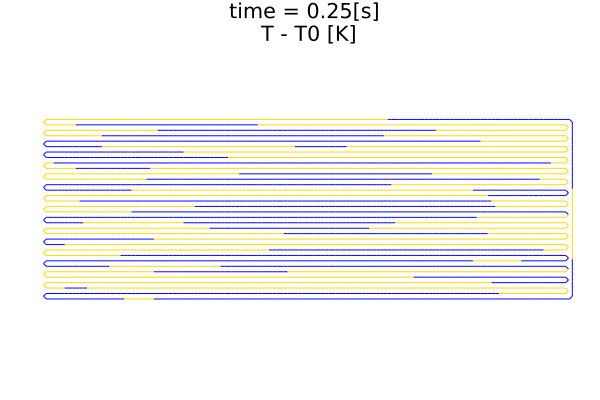

In [176]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=palette([:blue, :gold], 100),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

In [196]:
sysfinal[1].vapor.δ

30-element Array{Float64,1}:
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 ⋮
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5
 1.0e-5

In [201]:
XptoLliquidslug(sysfinal[end-1].liquid.Xp,L)

34-element Array{Float64,1}:
 0.14098882783990696
 0.23311138213070004
 0.0358910215894368
 0.04892018120160735
 0.039555031297060506
 0.014020965074379887
 0.008047636017921356
 0.05065111129286093
 0.040889028193099364
 0.011024301079519017
 0.10719477359281715
 0.08019198451633791
 0.010636881349422644
 ⋮
 0.019137936673312206
 0.03834253854381775
 0.04629816718278912
 0.027390401979126455
 0.06838285906784214
 0.2362818067476644
 0.010344577231963248
 0.0315339491597284
 0.21381120964404277
 0.02120916539004991
 0.14933077982279164
 0.01733944017505129

In [121]:
sysfinal[end-2].liquid.Xp

127-element Array{Tuple{Float64,Float64},1}:
 (2.683980350211747, 2.7476416175962504)
 (2.7739641345470774, 2.7793136274172965)
 (2.7811433836051855, 2.8119636660480727)
 (2.813702367946241, 2.8252260829061044)
 (2.826591068481968, 2.8340160053787833)
 (2.8359185374157723, 2.844170867943165)
 (3.150439337601071, 3.1565352638947712)
 (3.166651745697951, 3.172882389551175)
 (3.1741640683426273, 3.1797654056672457)
 (3.181622496097174, 3.1866318518519337)
 (3.240675130128807, 3.280449054934838)
 (3.282380803494612, 3.290776246325514)
 (3.3286100498666915, 3.3364656168472173)
 ⋮
 (2.4079271188756555, 2.4130022769684456)
 (2.41441974522159, 2.426819765951195)
 (2.463083321041258, 2.4726438736229257)
 (2.4737480236381075, 2.47876652426779)
 (2.4805962841667726, 2.4883654389806087)
 (2.4909257548758554, 2.5502660617059667)
 (2.5519965858298543, 2.5623646945561065)
 (2.5654961781211005, 2.5744928185153584)
 (2.6211036407650283, 2.631357559417617)
 (2.633111801475772, 2.6577339549265027)
 (2.65

In [122]:
maximum(sysfinal[end].liquid.dXdt)

(0.008426914677886359, 0.008426914677886359)

In [123]:
minimum(XptoLvaporplug(sysfinal[40].liquid.Xp,L,closedornot))

LoadError: [91mBoundsError: attempt to access 33-element Array{Any,1} at index [40][39m

In [124]:
0.6*5e-4

0.0003

# plot the OHP

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
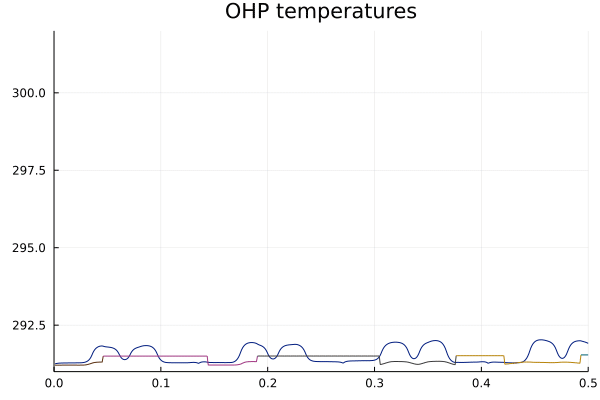

In [178]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T",ylim=(291.0,302.0),xlim=(0.0,0.5))
end

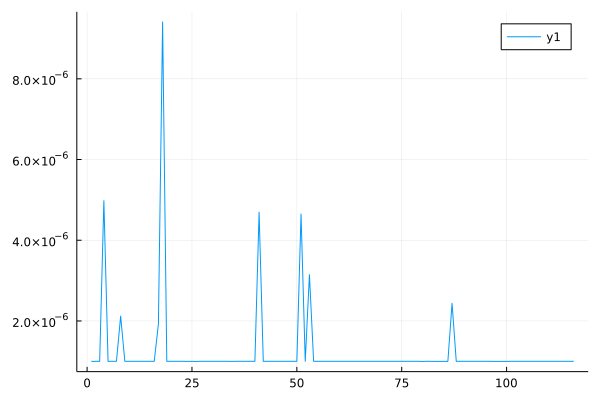

In [135]:
plot(sysfinal[10].vapor.δ)

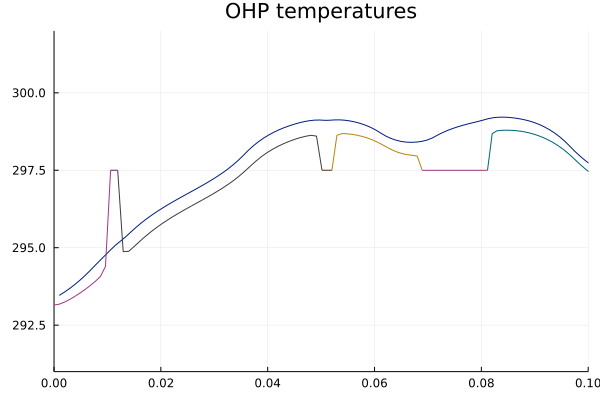

In [126]:
plot(sysfinal[end],plottype="T",ylim=(291.0,302.0),xlim=(0.0,0.1))

In [ ]:
plot(sysfinal[end-1],plottype="T",ylim=(291.0,302.0),xlim=(4.6,4.66))

In [ ]:
@gif for ii=1:length(sysfinal)
    plot(sysfinal[ii],plottype="T",ylim=(291.0,302.0),xlim=(4.5,5.0))
end

In [ ]:
plot(sysfinal[end-30],plottype="T",ylim=(291.0,292.0),xlim=(0.0,0.5))

In [ ]:
plot(sys.qline[1].arccoord,sys.qline[1].q)

In [ ]:
plot(temperature(plate_hist[end-1]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=string("time =  [s] \n",  "T - T0 [K]"))

In [ ]:
Tmax = maximum(temperature(plate_hist[end-1])[:])
Tmin = Tᵥ
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1  
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,clim=(Tmin,Tmax),color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"))
end

In [190]:
save("plate_ref_DT0.3_H2250_Delta1.0.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [191]:
save("tube_ref_DT0.3_H2250_Delta1.0.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

In [ ]:
# plate_hist, integrator_plate = load("plate_OHP_dimensional50D0.3TH1_fixed_new.jld2", "plate_hist",  "integrator_plate")
# sys = integrator_plate.p

In [ ]:
# tube_hist, integrator_tube = load("tube_OHP_dimensional50D0.3TH1_fixed_new.jld2", "tube_hist",  "integrator_tube")

# sysfinal = []
# for i = 1:length(tube_hist)
#     push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
# end

In [179]:
RTDx,RTD1,RTD4 = load("RTD.jld2","RTDx","RTD1","RTD4")

┌ Error: Failed to revise C:\Users\liyux\.julia\packages\Tokenize\FGrTw\src\lexer.jl
│   exception = Revise.ReviseEvalException("C:\\Users\\liyux\\.julia\\packages\\Tokenize\\FGrTw\\src\\lexer.jl:1105", TypeError(:typeassert, "", JuliaInterpreter.FrameCode, 306 => :ALMOST_EQUAL_OR_EQUAL_TO), Any[(Symbol(::Tokenize.Tokens.Kind) at Enums.jl:26, 1), (print(::Base.GenericIOBuffer{Array{UInt8,1}}, ::Tokenize.Tokens.Kind) at Enums.jl:28, 1), (print_to_string(::Tuple{Tokenize.Tokens.Kind}) at io.jl:135, 1), (string(::Tuple{Tokenize.Tokens.Kind}) at io.jl:174, 1), ((::Tokenize.Lexers.var"#3#4")(::Tokenize.Tokens.Kind) at none:0, 1), (iterate(::Base.Generator{Array{Tokenize.Tokens.Kind,1},Tokenize.Lexers.var"#3#4"}, ::Tuple{}) at generator.jl:47, 1), (_all(::Base.var"#256#258", ::Base.Generator{Array{Tokenize.Tokens.Kind,1},Tokenize.Lexers.var"#3#4"}, ::Colon) at reduce.jl:827, 1), (all(::Base.var"#256#258", ::Base.Generator{Array{Tokenize.Tokens.Kind,1},Tokenize.Lexers.var"#3#4"}) at reduce.jl

(0:53, [291.2, 291.2, 291.6, 291.8, 292.1, 292.5, 292.7, 293.1, 293.1, 293.6  …  295.8, 295.7, 295.7, 295.9, 295.9, 295.9, 296.1, 295.7, 295.9, 295.9], [291.2, 292.7, 294.0, 295.0, 295.6, 296.3, 296.8, 297.3, 297.7, 298.1  …  301.2, 301.3, 301.4, 301.4, 301.4, 301.5, 301.4, 301.7, 301.6, 301.6])

In [180]:
x = [-3.0inch,0.0]
y = [0.0,0.0]

X =  VectorData(x,y);

In [181]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [182]:
ghist = []

size(g)
for j = 1:length(g)
    gtemp = []
    for i = 1:length(plate_hist)
        H(g,temperature(plate_hist[i]))
        append!(gtemp,deepcopy(g[j]))
    end
    push!(ghist,deepcopy(gtemp))
end

In [183]:


thist = []
    for i = 1:length(tube_hist)
        append!(thist,tube_hist[i].t)
    end

In [184]:
# ghist = [Tᵥ;Tᵥ]
# for i = 1:length(plate_hist)
#     H(g,temperature(plate_hist[i]))
# #     println(g)
# #     push!(ghist,deepcopy(g))
#     ghist = hcat(ghist,g)
#     append!(thist,plate_hist[i].t)
# end


In [185]:
ghist

2-element Array{Any,1}:
 Any[291.2056666978493, 291.2496267468106, 291.3314481652433, 291.42048179115125, 291.56215416876523, 291.7361953857019, 291.9330053232577, 292.1166814959968, 292.2753001576974, 292.43690401615834  …  296.19988099148446, 296.40996849078, 296.48262251088124, 296.46400141513845, 296.4737512552092, 296.5135756803038, 296.52183745172056, 296.56222298576324, 296.6143122993062, 296.61972560477]
 Any[291.44229286083527, 291.8655989476304, 292.26808581727454, 292.5295691300488, 292.81895069142, 293.1064100775555, 293.34398385404376, 293.5666718386954, 293.77708057338117, 294.0016147133407  …  300.8153661622748, 300.8260839959914, 300.8599604678185, 300.9029514650778, 300.9053710014929, 300.84873591046113, 300.85564187153597, 300.8169990715794, 300.85516822009544, 300.86524222275744]

In [186]:
thist[1,:]

1-element Array{Any,1}:
 0.2495000000000002

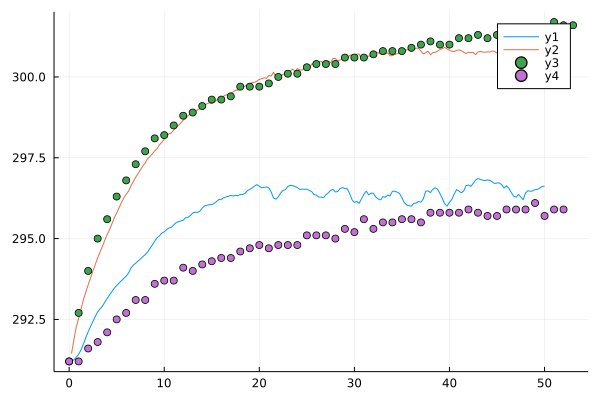

In [187]:
plot(thist,ghist[1])
plot!(thist,ghist[2])
scatter!(RTDx,RTD4)
scatter!(RTDx[1:end-1],RTD1)

In [188]:
sysfinal[end].liquid.Xp[4][2]-sysfinal[end].liquid.Xp[4][1]

0.04892018120160735

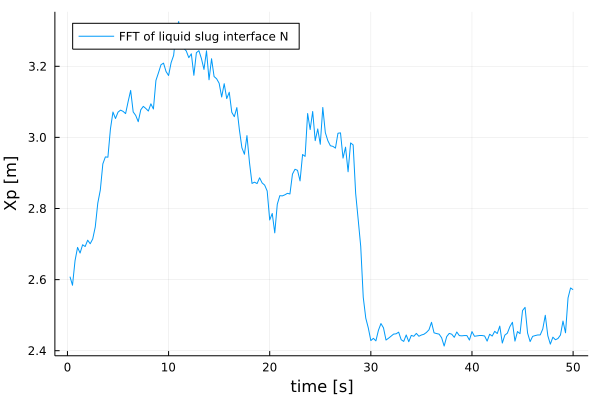

In [189]:
Xp_hist = zeros(length(sysfinal))
num = 2
for i = 1:length(sysfinal)
    for j = length(sysfinal[i].liquid.Xp)
#         Xp_hist[i] = sysfinal[i].liquid.Xp[end][end]
        Xp_hist[i] = sysfinal[i].liquid.Xp[1][1]
    end
end

# plot(thist,Xp_hist,label= "FFT of liquid slug interface 1",xlabel="FFT frequency [Hz]")
plot(thist,Xp_hist,label= "FFT of liquid slug interface N",xlabel="time [s]",ylabel="Xp [m]",legend=:topleft)

In [ ]:
dtt = 0.01
fs = 1/dtt

In [ ]:
LL = length(Xp_hist)
Y= fft(Xp_hist .- sum(Xp_hist)./LL )

P2 = abs.(Y/LL);
P1 = P2[1:Int64((LL-1)/2+1)];
P1[2:end-1] = 2*P1[2:end-1];
plot(LinRange(0.0,0.5fs,length(P1)),P1,xlim=(0,20),label= "FFT of liquid slug interface 1",xlabel="FFT frequency [Hz]")

In [ ]:
plot(Xp1_hist)

In [ ]:

velocity_avg = zeros(length(sysfinal))
velocity_max = zeros(length(sysfinal))

for i = 1:length(sysfinal)
    tmp = 0
    for j = length(sysfinal[i].liquid.dXdt)
        tmp += abs(sysfinal[i].liquid.dXdt[j][1])
    
        velocity_avg[i] = tmp/j
    end
    
    velocity_max[i] = maximum(abs.(sysfinal[i].liquid.dXdt[:][1]))
end



In [ ]:
plot(thist,velocity_avg,label="v avg")
plot!(thist,velocity_max,label="v max",xlabel="t [s]", ylabel="v [m/s]")

In [ ]:
d = tube_d
δmin = 5e-3*d

In [ ]:
δmin:1e-6:d/2

In [ ]:
Hfilm

## film H v.s. thickness

In [ ]:
sys0.vapor.δmin

In [ ]:
plot(0.0:1e-8:tube_d/8,Hfilm.(0.0:1e-8:tube_d/8,[sys0]),xlabel="δ[m]",ylabel="h [W/m²/K]")

### Total mass of the system

In [217]:


thist = []
    for i = 1:length(tube_hist)
        append!(thist,tube_hist[i].t)
    end

In [218]:
# i = 100
Mass = zeros(length(sysfinal))
M1hist = zeros(length(sysfinal))
M2hist = zeros(length(sysfinal))
M3hist = zeros(length(sysfinal))
for i = 1:length(sysfinal)
    δarea = Ac .* (1 .- ((tube_d .- 2*sysfinal[i].vapor.δ ) ./ tube_d) .^ 2);
    Lvaporplug = XptoLvaporplug(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
    Lliquidslug = XptoLliquidslug(sysfinal[i].liquid.Xp,sysfinal[i].tube.L)
    δarea .* Lvaporplug .* ρₗ .+ PtoD.(sysfinal[i].vapor.P) .* (Ac .- δarea) .* Lvaporplug
    M1 = δarea .* Lvaporplug .* ρₗ
    M2 = PtoD.(sysfinal[i].vapor.P) .* (Ac .- δarea) .* Lvaporplug
    M3 = ρₗ .* Ac .* Lliquidslug
    
    Mass[i] = sum(M1+M2)+sum(M3)
    M1hist[i] = sum(M1)
    M2hist[i] = sum(M2)
    M3hist[i] = sum(M3)
#     Mass[i] = sum(M1)
end
# println(sum(M1+M2)+sum(M3))
# println(sum(M1+M2))
# println(sum(M3))
# plot(M3hist/Mass[1])
# subplot(Mass/Mass[1])

In [219]:
M3hist[5:30]/Mass[1]

26-element Array{Float64,1}:
 0.9533256434709293
 0.9533263499321349
 0.9533275149717204
 0.9533292906120645
 0.953331843643177
 0.9533353563013626
 0.9533400215222311
 0.9533460436246832
 0.9533536333248123
 0.9533630009237792
 0.9533743699353725
 0.9533879640813773
 0.9534040075666571
 0.9534226575614319
 0.953443953544091
 0.9534678635512088
 0.9534943412329921
 0.9535233554484123
 0.9535549050027643
 0.9535890034934755
 0.9536256770515424
 0.9536649122811163
 0.9537066305483871
 0.9537506465763502
 0.9537968867236318
 0.9538453656822289

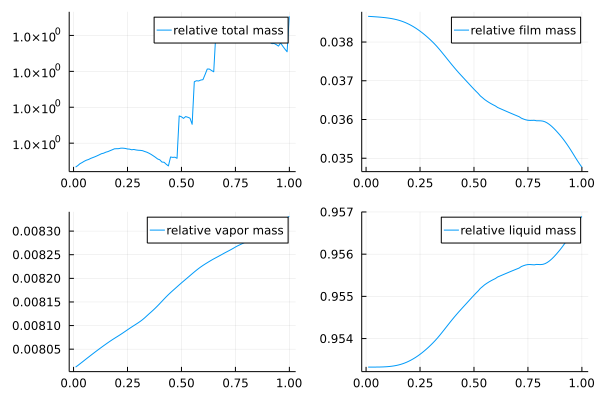

GKS: Possible loss of precision in routine SET_WINDOW


In [220]:
l = @layout [a b ; c d]
p1 = plot(thist,Mass/Mass[1],label = "relative total mass")
p2 = plot(thist,M1hist/Mass[1],label = "relative film mass")
p3 = plot(thist,M2hist/Mass[1],label = "relative vapor mass")
p4 = plot(thist,M3hist/Mass[1],label = "relative liquid mass")
plot(p1, p2, p3, p4, layout = l)

In [195]:
Mass/Mass[1]

200-element Array{Float64,1}:
 1.0
 1.0000988989344661
 1.000173819278166
 1.0002374504529972
 1.0003028098422295
 1.0003663003876548
 1.0004382006265364
 1.0004935239451076
 1.0005598375419218
 1.00060567066289
 1.0006636275711582
 1.0007134388353478
 1.0007581836645825
 ⋮
 1.0025837036811733
 1.0024971462056933
 1.002507817805851
 1.002468659318244
 1.0025898587683262
 1.0025221477320803
 1.0025368651056723
 1.0025514824145028
 1.0024907864132195
 1.0025517203250187
 1.0025246128572995
 1.0025444541228914

In [ ]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=palette([:blue, :gold], 100),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end